<a href="https://colab.research.google.com/github/godpeny/laboratory/blob/master/Study/Deep_Learning_for_Everyone/Chapter_5/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install
%pip install pandas
%pip install numpy
%pip install tensorflow
%pip install sklearn
%pip install matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2952 sha256=36762b832c9806a4c2d802b9c5b6fab887500f446bfee4d0224f191bcc25ccc8
  Stored in directory: /root/.cache/pip/wheels/33/a3/d2/092b519e9522b4c91608b7dcec0dd9051fa1bff4c45f4502d1
Successfully built sklearn


In [ ]:
# import
import pandas as pd
import numpy as np

from google.colab import drive

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, BatchNormalization, Reshape, Activation, UpSampling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#DCGAN
 - https://wikidocs.net/146362

In [ ]:
"""
generator modeling
"""
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D()) # 14 * 14 * `128
generator.add(Conv2D(filters=64, kernel_size=(5,5), padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # 28 * 28 * 128
generator.add(Conv2D(filters=1, kernel_size=(5,5), padding='same', activation='tanh'))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

#BatchNormalization
 - Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
 - why use?: https://towardsdatascience.com/batch-normalization-8a2e585775c9#:~:text=Batch%20normalization%20optimizes%20network%20training,to%20train%20during%20back%20propagation.

#Conv2D
 - filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
 - padding: "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.

In [ ]:
"""
discriminator modeling

basically using ordinary CNN.
"""
discriminator = Sequential()
discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), input_shape=(28,28,1), padding='same')) # (28,28) -> (14,14) due to stride
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')) # (14,14) -> (7,7) due to stride
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid')) # using sigmoid to determine True or False

discriminator.summary()

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # discriminator is not training. only determining.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

#Model vs Sequential in keras
 - Use the Sequential API when your model is a simple stack of layers with single input leading to a single output.
 - Use the Functional Model API when you need more flexibility like multiple inputs, multiple outputs, shared layers, etc.

In [ ]:
"""
GAN modeling
"""
input_gen = Input(shape=(100,))
g_output = generator(input_gen)
d_output = discriminator(g_output)
gan = Model(inputs=input_gen, outputs=d_output)

gan.summary()

gan.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


#model.train_on_batch
Runs a single gradient update on a single batch of data.

#model.predict
Generates output predictions for the input samples.




In [ ]:
"""
main function
"""
def run(epoch, batch_size, saving_interval):
  # load mnist datasets. only train sets are needed.
  (X_train, _), (_, _) = mnist.load_data() # X_train.shape = (60000, 28, 28)
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32') # Black color only
  X_train = (X_train - 127.5) / 127.5 # since X_train data element is value between 0~255, make it between -1 ~ 1

  # true & fake arrays
  true = np.ones((batch_size, 1)) # return array with true
  fake = np.zeros((batch_size, 1)) # return array with false

  for i in range(epoch):
    # real image
    indexes = np.random.randint(0, X_train.shape[0], batch_size) # pick 'batch_size' samples from 'X_train'
    imgs = X_train[indexes]
    d_loss_real = discriminator.train_on_batch(imgs, true) # train real images as true

    # fake image
    noise = np.random.normal(0.0, 1.0, (batch_size, 100))
    imgs_gen = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(imgs_gen, fake) # train fake images as fake

    # calculate loss of discriminator and generator
    d_loss = np.add(d_loss_real, d_loss_fake) * (1/2)
    g_loss = gan.train_on_batch(noise, true) # generator always consider its result as true


    # print
    print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

    # save image on interval
    if i % saving_interval == 0:
      noise = np.random.normal(0, 1, (25, 100))
      imgs_gen_interval = generator.predict(noise)

      # rescale images [-1,1] from [0,1]
      imgs_gen_interval = (0.5 * imgs_gen_interval) + 0.5

      fig, axs = plt.subplots(5,5)
      count = 0
      for j in range(5):
        for k in range(5):
          axs[j, k].imshow(imgs_gen_interval[count, :, :, 0], cmap='gray')
          axs[j, k].axis('off')
          count += 1
      fig.show()

#Why noise in GAN?
https://towardsdatascience.com/why-do-gans-need-so-much-noise-1eae6c0fb177

1/1 [==============================] - 0s 25ms/step
epoch:0  d_loss:0.4354  g_loss:1.7409
1/1 [==============================] - 0s 24ms/step
epoch:1  d_loss:0.4866  g_loss:1.6642
1/1 [==============================] - 0s 29ms/step
epoch:2  d_loss:0.4108  g_loss:1.3757
1/1 [==============================] - 0s 28ms/step
epoch:3  d_loss:0.5759  g_loss:1.2159
1/1 [==============================] - 0s 27ms/step
epoch:4  d_loss:0.4450  g_loss:1.6308
1/1 [==============================] - 0s 28ms/step
epoch:5  d_loss:0.3369  g_loss:1.9044
1/1 [==============================] - 0s 27ms/step
epoch:6  d_loss:0.6374  g_loss:1.5415
1/1 [==============================] - 0s 24ms/step
epoch:7  d_loss:0.5521  g_loss:1.3066
1/1 [==============================] - 0s 25ms/step
epoch:8  d_loss:0.5873  g_loss:1.5253
1/1 [==============================] - 0s 26ms/step
epoch:9  d_loss:0.5582  g_loss:1.5692
1/1 [==============================] - 0s 26ms/step
epoch:10  d_loss:0.4525  g_loss:1.4789
1/1 [====

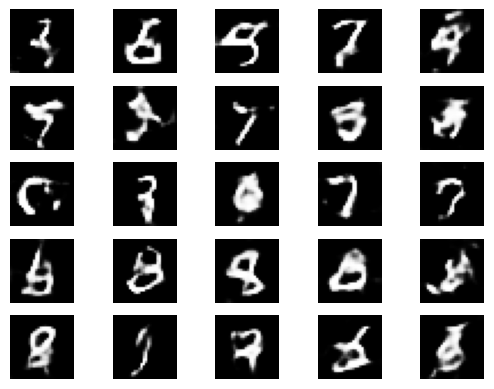

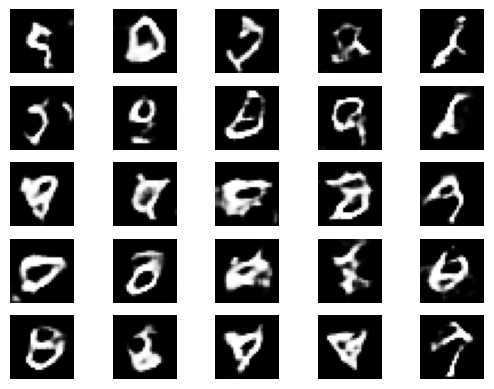

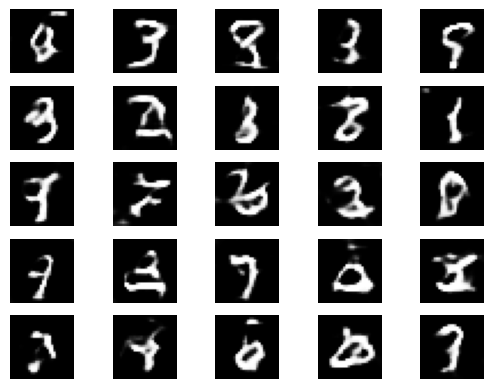

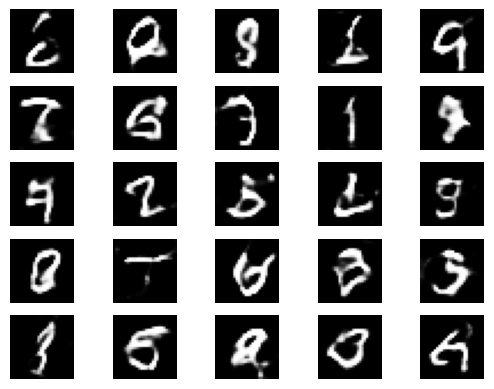

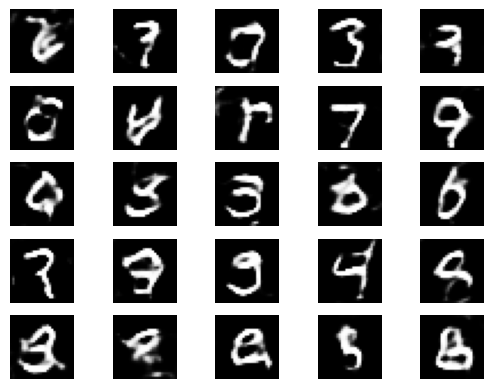

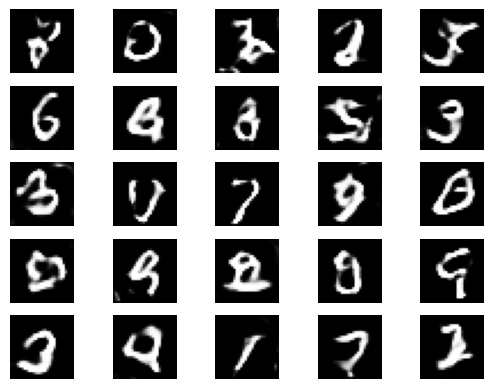

In [ ]:
"""
run
"""
run(2001, 32, 400)